<a href="https://colab.research.google.com/github/cnbltyasar/ML-classification-with-pyrimen-/blob/main/MLwithPyrimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive
!ls

/gdrive
MyDrive


In [4]:
import os

os.chdir('/gdrive/MyDrive/Colab_Notebooks')

In [5]:
!ls

 Emotion_Recognition.ipynb	'ML Assignment3YC.ipynb'
 eyeAdgFinalFeatures.csv	 PrevEyeData.mat
 eyeBlinkingAbdullah1.csv	 RPA_stepbystep.ipynb
 eyeBlinkingAbdullah1.mat	 RPA_trial.ipynb
 EyeData.mat			 RPAwithGroup.ipynb
 EyeData_v2.mat			 save_models
 EyeOCSubject1Ch6.mat		 SDP_preprocess.ipynb
 fashionmnist.ipynb		 SPDfinal.ipynb
 Fashion_MNIST.ipynb		'SPD(symmetric_positive_definitive).ipynb'
 fer2013.csv			 Untitled0.ipynb
'Katmanlar ve Modeller.ipynb '


In [11]:
!pip install pyriemann
!pip install mat73
!pip install mne
import mat73
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from pyriemann.classification import MDM
from pyriemann.utils.distance import distance_riemann 
from tqdm import tqdm
from collections import OrderedDict
from scipy.io import loadmat
import numpy as np
import itertools
from mne.filter import filter_data
from pyriemann.estimation import Covariances

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 2.3 MB/s 
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78032 sha256=24ac8ddbb46e49b2bdd26a6551beae74073de77ff29df5fda96dc1559cb5c4f2
  Stored in directory: /root/.cache/pip/wheels/0b/1b/bf/a537f9e17e6c3490004ede419c72f863af1d0d765d25e532ef
Successfully built pyriemann
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 3.8 MB/s 


In [12]:
root = '/gdrive/MyDrive/Colab_Notebooks'
data = loadmat(root + '/EyeData_v2.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'adg_180', 'adg_360', 'emre_180', 'emre_360', 'emre_plus_adg_540'])

In [13]:
X = data['adg_180']
X.shape

(180, 4, 256)

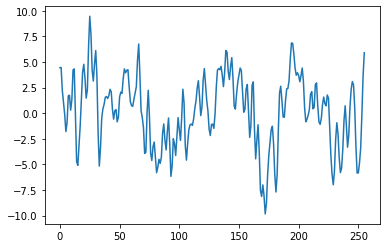

In [15]:
plt.plot(X[2][0][:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
80.0


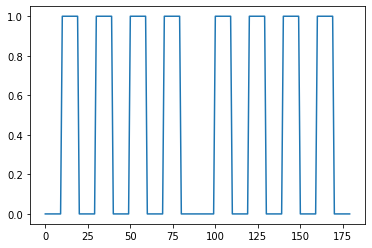

In [22]:
ones = np.zeros(90)
for i in range(90):
  if i > 9 and i<20:
    ones[i] = 1
  elif i > 29 and i<40:
    ones[i] = 1
  elif i > 49 and i<60:
    ones[i] = 1
  elif i > 69 and i<80:
    ones[i] = 1



print(ones)
a1 = ones
Label = np.concatenate((a1, a1), axis=0, out=None, dtype=None, casting="same_kind")
print(np.sum(Label))
plt.plot(Label)

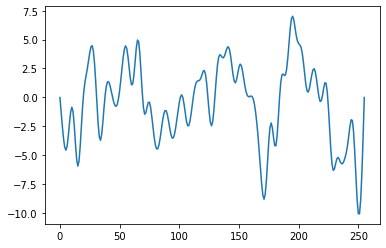

In [25]:
from mne.filter import filter_data
from pyriemann.estimation import Covariances
fs = 256
filtered_eeg = filter_data(data = X,sfreq = fs,l_freq = 2.0, h_freq = 30.0, method='iir',verbose=0)

plt.plot(filtered_eeg[2][0][:])

Classifffication by using larger Data

In [27]:
from pyriemann.utils.base import invsqrtm
def parallel_transport_covariance_matrix(C, R):
    return np.dot(invsqrtm(R), np.dot(C, invsqrtm(R)))

def recenter_data(data, transform_point, verbose=True):
    temp = []
    for Ci in data['covs']:
        temp.append(parallel_transport_covariance_matrix(Ci,transform_point))
    data_rct = {}
    data_rct['covs'] = np.stack(temp)
    data_rct['labels'] = data['labels']
    if verbose:
        print(data_rct['covs'].shape)
    return data_rct

In [45]:
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from pyriemann.tangentspace import TangentSpace
from random import randrange
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from pyriemann.tangentspace import TangentSpace
from random import randrange
from sklearn import linear_model


In [38]:
def get_conv_matrix(X, epoch_start = 0, epoch_duration = 1):
  from mne.filter import filter_data
  from pyriemann.estimation import Covariances

  fs = 256
  filtered_eeg = filter_data(data = X,sfreq = fs,l_freq = 2.0, h_freq = 30.0, method='iir',verbose=0)

  epoch_end = epoch_start + epoch_duration
  epoch = filtered_eeg[:,:,int(epoch_start*fs):int(epoch_end*fs+1)]
  covs = Covariances().transform(X = epoch)

  from pyriemann.utils.mean import mean_riemann
  mean_source = mean_riemann(covs)
    
  ones = np.zeros(90)
  for i in range(90):
    if i > 9 and i<20:
      ones[i] = 1
    elif i > 29 and i<40:
      ones[i] = 1
    elif i > 49 and i<60:
      ones[i] = 1
    elif i > 69 and i<80:
      ones[i] = 1
  a1 = ones
  Label = np.concatenate((a1, a1), axis=0, out=None, dtype=None, casting="same_kind")

  data['covs'] = covs
  data['labels'] = Label
  source_rct = recenter_data(data=data, transform_point=mean_source)

  return source_rct['covs'], source_rct['labels']


In [39]:
def get_conv_matrix360(X, epoch_start = 0, epoch_duration = 1):
  from mne.filter import filter_data
  from pyriemann.estimation import Covariances

  fs = 256
  filtered_eeg = filter_data(data = X,sfreq = fs,l_freq = 2.0, h_freq = 30.0, method='iir',verbose=0)

  epoch_end = epoch_start + epoch_duration
  epoch = filtered_eeg[:,:,int(epoch_start*fs):int(epoch_end*fs+1)]
  covs = Covariances().transform(X = epoch)

  from pyriemann.utils.mean import mean_riemann
  mean_source = mean_riemann(covs)
    
  ones = np.zeros(90)
  for i in range(90):
    if i > 9 and i<20:
      ones[i] = 1
    elif i > 29 and i<40:
      ones[i] = 1
    elif i > 49 and i<60:
      ones[i] = 1
    elif i > 69 and i<80:
      ones[i] = 1
  a1 = ones
  Label = np.concatenate((a1, a1, a1, a1), axis=0, out=None, dtype=None, casting="same_kind")

  data['covs'] = covs
  data['labels'] = Label
  source_rct = recenter_data(data=data, transform_point=mean_source)

  return source_rct['covs'], source_rct['labels']


In [40]:
def get_conv_matrix540(X, epoch_start = 0, epoch_duration = 1):
  from mne.filter import filter_data
  from pyriemann.estimation import Covariances

  fs = 256
  filtered_eeg = filter_data(data = X,sfreq = fs,l_freq = 2.0, h_freq = 30.0, method='iir',verbose=0)

  epoch_end = epoch_start + epoch_duration
  epoch = filtered_eeg[:,:,int(epoch_start*fs):int(epoch_end*fs+1)]
  covs = Covariances().transform(X = epoch)

  from pyriemann.utils.mean import mean_riemann
  mean_source = mean_riemann(covs)
    
  ones = np.zeros(90)
  for i in range(90):
    if i > 9 and i<20:
      ones[i] = 1
    elif i > 29 and i<40:
      ones[i] = 1
    elif i > 49 and i<60:
      ones[i] = 1
    elif i > 69 and i<80:
      ones[i] = 1
  a1 = ones
  Label = np.concatenate((a1, a1, a1, a1, a1, a1), axis=0, out=None, dtype=None, casting="same_kind")

  data['covs'] = covs
  data['labels'] = Label
  source_rct = recenter_data(data=data, transform_point=mean_source)

  return source_rct['covs'], source_rct['labels']


In [34]:
train_cov, train_labl = get_conv_matrix(X = data['adg_180'], epoch_start = 0, epoch_duration = 1)
data['adg_180'].shape
train_cov.shape
train_labl.shape

(180, 4, 4)


(180,)

In [65]:
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from pyriemann.tangentspace import TangentSpace
from random import randrange
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN

In [68]:
def classication_matrix(train_cov, train_labl):
  ts = TangentSpace()

  ldac = LDA()
  lrc = LR()
  svc = SVC(kernel='linear')
  lasso = Lasso(alpha=0.5, fit_intercept=False)
  dtc = DecisionTreeClassifier()
  KNN = KNeighborsClassifier() 
  rfc = RandomForestClassifier(n_estimators=100)

  accuracy_matrix  = []
  #add mdm
  clf = make_pipeline(ts, ldac)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv)
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = make_pipeline(ts, lrc)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv)
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = make_pipeline(ts, svc)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv)
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = make_pipeline(ts, lasso)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv, scoring='accuracy')
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = MDM()
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv, scoring='accuracy')
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = make_pipeline(ts, dtc)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv, scoring='accuracy')
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())


  clf = make_pipeline(ts, KNN)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv, scoring='accuracy')
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())



  clf = make_pipeline(ts, rfc)
  acc = []
  for i in range(20):
      # Cross validation
      cv = KFold(n_splits=10, shuffle=True, random_state=randrange(10000))
      scores = cross_val_score(clf, train_cov, train_labl, cv=cv, scoring='accuracy')
      acc.append(scores.mean())
  acc = np.array(acc)
  accuracy_matrix.append(acc.mean())

  return accuracy_matrix

(180, 4, 4)


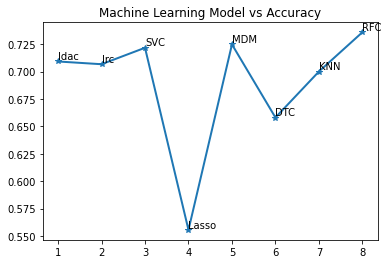

[0.7091666666666666, 0.7066666666666666, 0.7216666666666666, 0.5555555555555556, 0.7247222222222223, 0.6580555555555556, 0.7, 0.7358333333333335]
ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest 


In [112]:
train_cov, train_labl = get_conv_matrix(X = data['adg_180'], epoch_start = 0, epoch_duration = 1)

acc_matrix = classication_matrix(train_cov, train_labl)

# Preparing dataset
x = np.arange(1,9)
y = acc_matrix

# plotting scatter plot
plt.plot(x, y, marker="*", linewidth=2)

text = ["ldac", "lrc", "SVC", "Lasso", "MDM",
        "DTC", "KNN", "RFC",]

for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i] + 0.002))
plt.title("Machine Learning Model vs Accuracy")
plt.show()
print(y)
print("ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest ")

(180, 4, 4)


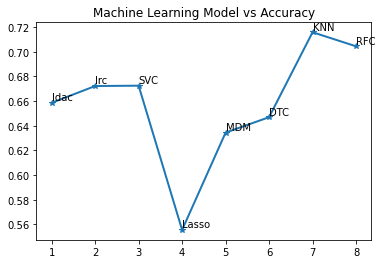

[0.6586111111111113, 0.6722222222222223, 0.6725000000000001, 0.5555555555555556, 0.6344444444444444, 0.6469444444444443, 0.7158333333333332, 0.7044444444444444]
ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest 


In [113]:
train_cov, train_labl = get_conv_matrix(X = data['emre_180'], epoch_start = 0, epoch_duration = 1)

acc_matrix = classication_matrix(train_cov, train_labl)

# Preparing dataset
x = np.arange(1,9)
y = acc_matrix

# plotting scatter plot
plt.plot(x, y, marker="*", linewidth=2)

text = ["ldac", "lrc", "SVC", "Lasso", "MDM",
        "DTC", "KNN", "RFC",]

for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i] + 0.002))
plt.title("Machine Learning Model vs Accuracy")
plt.show()
print(y)
print("ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest ")

(360, 4, 4)


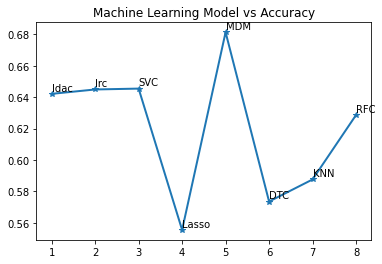

[0.6420833333333332, 0.6448611111111111, 0.6454166666666667, 0.5555555555555556, 0.68125, 0.573611111111111, 0.5876388888888889, 0.628611111111111]
ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest 


In [114]:
train_cov, train_labl = get_conv_matrix360(X = data['adg_360'], epoch_start = 0, epoch_duration = 1)

acc_matrix = classication_matrix(train_cov, train_labl)

# Preparing dataset
x = np.arange(1,9)
y = acc_matrix

# plotting scatter plot
plt.plot(x, y, marker="*", linewidth=2)

text = ["ldac", "lrc", "SVC", "Lasso", "MDM",
        "DTC", "KNN", "RFC",]

for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i] + 0.002))
plt.title("Machine Learning Model vs Accuracy")
plt.show()
print(y)
print("ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest ")

(360, 4, 4)


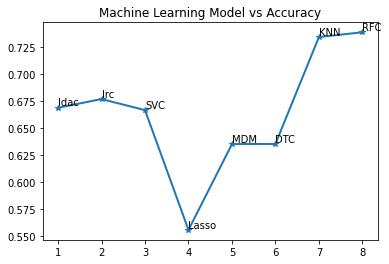

[0.6690277777777778, 0.6770833333333333, 0.6668055555555557, 0.5555555555555556, 0.6352777777777778, 0.6354166666666667, 0.7347222222222222, 0.7391666666666666]
ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest 


In [115]:
train_cov, train_labl = get_conv_matrix360(X = data['emre_360'], epoch_start = 0, epoch_duration = 1)

acc_matrix = classication_matrix(train_cov, train_labl)

# Preparing dataset
x = np.arange(1,9)
y = acc_matrix

# plotting scatter plot
plt.plot(x, y, marker="*", linewidth=2)

text = ["ldac", "lrc", "SVC", "Lasso", "MDM",
        "DTC", "KNN", "RFC",]

for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i] + 0.002))
plt.title("Machine Learning Model vs Accuracy")
plt.show()
print(y)
print("ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest ")

(540, 4, 4)


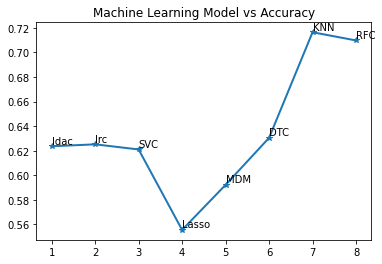

[0.6236111111111111, 0.6251851851851852, 0.6210185185185185, 0.5555555555555556, 0.5922222222222222, 0.630462962962963, 0.7163888888888889, 0.7097222222222223]
ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest 


In [116]:
train_cov, train_labl = get_conv_matrix540(X = data['emre_plus_adg_540'], epoch_start = 0, epoch_duration = 1)

acc_matrix = classication_matrix(train_cov, train_labl)

# Preparing dataset
x = np.arange(1,9)
y = acc_matrix

# plotting scatter plot
plt.plot(x, y, marker="*", linewidth=2)

text = ["ldac", "lrc", "SVC", "Lasso", "MDM",
        "DTC", "KNN", "RFC",]

for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i] + 0.002))
plt.title("Machine Learning Model vs Accuracy")
plt.show()
print(y)
print("ldac: LinearDiscriminantAnalysis, lrc:LogisticRegression ,SVC: Support Vector Machine, Lasso: , MDM: Minimum Distance to Mean,DTC: Decision Tree, KNN: K-nearest neighbors, RFC: Random Forest ")